In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm
import MDAnalysis as mda
import pandas as pd

In [2]:
chi_h5 = "/home/debian/water/TIP4P/Ice/225/shear/rst/chi4_results.h5"
store = pd.HDFStore(chi_h5, mode='r')
print("HDFStore keys:")
print(store.keys())

HDFStore keys:
['/1e-4', '/1e-6', '/5e-4', '/5e-5', '/5e-6', '/equili']


Max χ4 = 9.41091 at τ_chi = 13.80000 ps
Max χ4 = 4.66853 at τ_chi = 0.75000 ps
Max χ4 = 0.68029 at τ_chi = 0.25000 ps


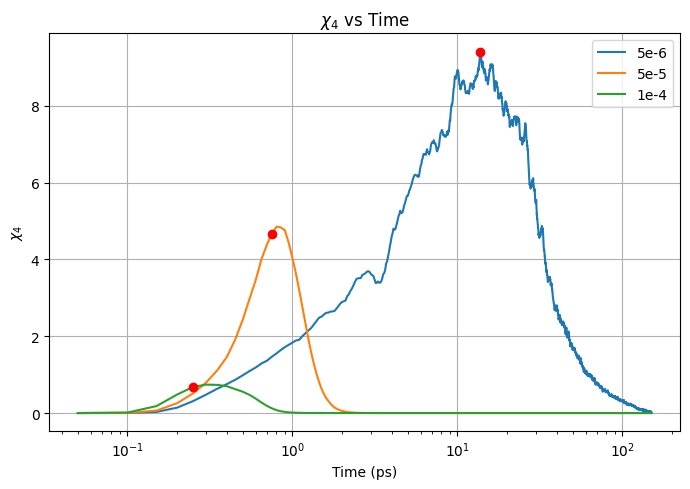

In [5]:
from chi_visualize import plot_chi
plt.figure(figsize=(7,5))
plot_chi("/home/debian/water/TIP4P/Ice/225/shear/rst/chi4_results.h5", "5e-6")
plot_chi("/home/debian/water/TIP4P/Ice/225/shear/rst/chi4_results.h5", "5e-5")
plot_chi("/home/debian/water/TIP4P/Ice/225/shear/rst/chi4_results.h5", "1e-4")
plt.xlabel("Time (ps)")
plt.ylabel(r"$\chi_4$")
plt.title(r"$\chi_4$ vs Time")
plt.xscale("log")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [2]:
h5_file = "/home/debian/water/TIP4P/Ice/225/shear/rst/non_trival_displacement_results.h5"

In [3]:
store = pd.HDFStore(h5_file, mode='r')
print("HDFStore keys:")
print(store.keys())

HDFStore keys:
['/1e-4', '/5e-5', '/equili']


In [3]:
df1 = pd.read_hdf(h5_file, key='/5e-6')
print(df1.head())

   O_index  event_frame
0        0          197
1        0          777
2        0         1372
3        0         1622
4        0         1820


In [4]:
print(df1.tail())

       O_index  event_frame
22307    12282         5497
22308    12285         1642
22309    12285         3168
22310    12285         4070
22311    12285         5233


### 画出时间分布图

In [5]:
waiting_time = df1.groupby("O_index")['event_frame'].diff()
print(waiting_time.describe())

count    18226.000000
mean       814.455997
std        654.831341
min          1.000000
25%        329.000000
50%        656.000000
75%       1125.000000
max       4928.000000
Name: event_frame, dtype: float64


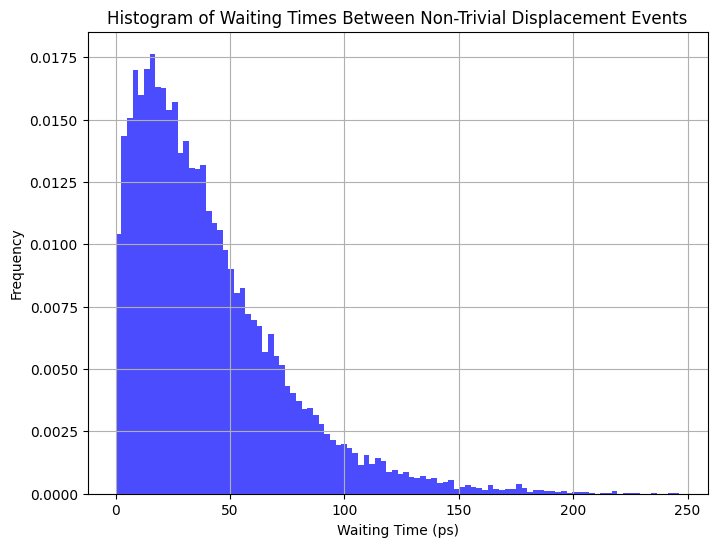

Peak waiting time: 16.06275 ps


In [7]:
# 画出 统计图
plt.figure(figsize=(8, 6))
plt.hist(waiting_time.dropna()*0.05, bins=100, density=True, color='blue', alpha=0.7)
plt.title('Histogram of Waiting Times Between Non-Trivial Displacement Events')
plt.xlabel('Waiting Time (ps)')
plt.ylabel('Frequency')
# plt.yscale('log')  # 如果分布跨度较大，可以考虑对y轴使用对数刻度
plt.grid(True)
plt.show()
# 指出最高点的位置
max_bin_index = np.argmax(np.histogram(waiting_time.dropna()*0.05, bins=100)[0])
bin_edges = np.histogram(waiting_time.dropna()*0.05, bins=100)[1]
peak_waiting_time = (bin_edges[max_bin_index] + bin_edges[max_bin_index + 1]) / 2
print(f"Peak waiting time: {peak_waiting_time} ps")

In [8]:
# 画出发生 non-trival displacement 时原子在空间上的分布图
u = mda.Universe("/home/debian/water/TIP4P/Ice/225/shear/traj_5e-6_225.0_new.lammpstrj", format="LAMMPSDUMP")
O_atoms = u.select_atoms("type 1") # 选择氧原子
coords = np.zeros(shape=(len(u.trajectory), O_atoms.n_atoms, 3))
for ts in tqdm(u.trajectory, desc="Extracting coordinates"):
    coords[ts.frame] = O_atoms.positions
shear_rate = 5e-6 * 1e3  # 1/ps
time_step = 0.05 # ps

/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/topology/LAMMPSParser.py:651: UserWarning: Guessed all Masses to 1.0
  warnings.warn("Guessed all Masses to 1.0")
/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/coordinates/LAMMPS.py:751: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt
Extracting coordinates: 100%|██████████| 6001/6001 [05:46<00:00, 17.32it/s]


In [9]:
# 计算对于单粒子的 non-trival displacement
def apply_shear_correction(coords, shear_rate, time_step, ref_y=25.0):
    T = coords.shape[0]
    y = coords[:, :, 1] - ref_y  # shape (T, N)
    gamma_dt = shear_rate * time_step
    shear_disp = gamma_dt * np.cumsum(y, axis=0)  # shape (T, N)
    coords[:, :, 0] -= shear_disp
    return coords


In [10]:
coords_corrected = apply_shear_correction(coords, shear_rate, time_step)

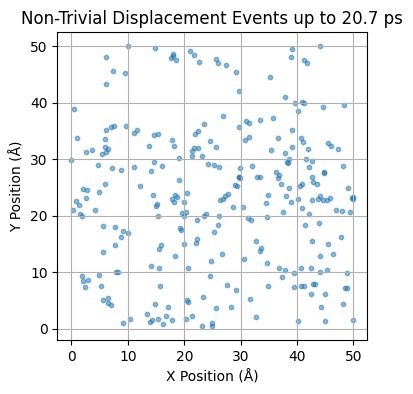

In [11]:
# 画出发生在 t_chi 时刻内非平凡位移的原子分布图
time_chi = 20.7 # ps
frame_chi = int(time_chi / time_step)
idx = np.where((df1['event_frame'] < frame_chi))[0]
O_indices, event_frames = df1.iloc[idx][['O_index', 'event_frame']].values.T
# 对修正后的坐标采用 周期性边界条件
box = np.array([50.0, 50.0, 50.0])  # 根据实际模拟盒子尺寸进行调整

plt.figure(figsize=(4, 4))
plt.scatter(coords_corrected[event_frames, O_indices//3, 0] % box[0],
            coords_corrected[event_frames, O_indices//3, 1] % box[1],
            s=10, alpha=0.5)
plt.title(f'Non-Trivial Displacement Events up to {time_chi} ps')
plt.xlabel('X Position (Å)')
plt.ylabel('Y Position (Å)')
plt.axis('equal')
plt.grid(True)
plt.show()

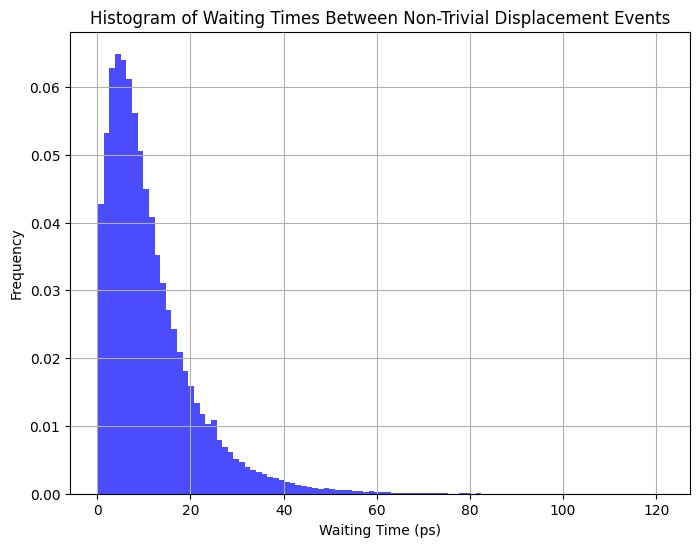

/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/topology/LAMMPSParser.py:651: UserWarning: Guessed all Masses to 1.0
  warnings.warn("Guessed all Masses to 1.0")
/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/coordinates/LAMMPS.py:751: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt
Extracting coordinates: 100%|██████████| 2000/2000 [01:22<00:00, 24.24it/s]


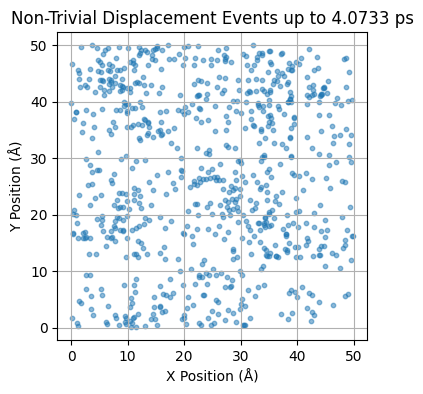

In [5]:
df2 = pd.read_hdf(h5_file, key='/5e-5')
waiting_time = df2.groupby("O_index")['event_frame'].diff()[1:]
plt.figure(figsize=(8, 6))
plt.hist(waiting_time.dropna()*0.2, bins=100, density=True, color='blue', alpha=0.7)
plt.title('Histogram of Waiting Times Between Non-Trivial Displacement Events')
plt.xlabel('Waiting Time (ps)')
plt.ylabel('Frequency')
# plt.yscale('log')  # 如果分布跨度较大，可以考虑对y轴使用对数刻度
plt.grid(True)
plt.show()
u = mda.Universe("/home/debian/water/TIP4P/Ice/225/shear/traj_5e-5_225.0.lammpstrj", format="LAMMPSDUMP")
O_atoms = u.select_atoms("type 1") # 选择氧原子
coords_2 = np.zeros(shape=(len(u.trajectory[2000:4000]), O_atoms.n_atoms, 3))
for ts in tqdm(u.trajectory[2000:4000], desc="Extracting coordinates"):
    coords_2[ts.frame - 2000] = O_atoms.positions
shear_rate = 5e-5 * 1e3 # 转换为 ps^-1
time_step = 0.2 # ps
coords_corrected_2 = apply_shear_correction(coords_2, shear_rate, time_step)
time_chi = 4.07330 # ps
frame_chi = int(time_chi / time_step)
idx = np.where((df2['event_frame'] < frame_chi))[0]
O_indices, event_frames = df2.iloc[idx][['O_index', 'event_frame']].values.T
# 对修正后的坐标采用 周期性边界条件
box = np.array([50.0, 50.0, 50.0])  # 根据实际模拟盒子尺寸进行调整
plt.figure(figsize=(4, 4))
plt.scatter(coords_corrected_2[event_frames, O_indices//3, 0] % box[0],
            coords_corrected_2[event_frames, O_indices//3, 1] % box[1],
            s=10, alpha=0.5)
plt.title(f'Non-Trivial Displacement Events up to {time_chi} ps')
plt.xlabel('X Position (Å)')
plt.ylabel('Y Position (Å)')
plt.axis('equal')
plt.grid(True)
plt.show()

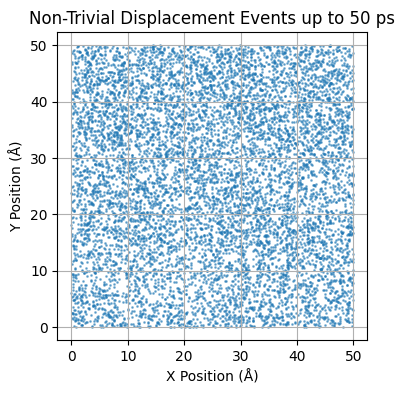

In [10]:
time_chi = 50 # ps
frame_chi = int(time_chi / time_step)
idx = np.where((df2['event_frame'] < frame_chi))[0]
O_indices, event_frames = df2.iloc[idx][['O_index', 'event_frame']].values.T
# 对修正后的坐标采用 周期性边界条件
box = np.array([50.0, 50.0, 50.0])  # 根据实际模拟盒子尺寸进行调整
plt.figure(figsize=(4, 4))
plt.scatter(coords_corrected_2[event_frames, O_indices//3, 0] % box[0],
            coords_corrected_2[event_frames, O_indices//3, 1] % box[1],
            s=1, alpha=0.5)
plt.title(f'Non-Trivial Displacement Events up to {time_chi} ps')
plt.xlabel('X Position (Å)')
plt.ylabel('Y Position (Å)')
plt.axis('equal')
plt.grid(True)
plt.show()

### 检查一下某帧中 velocity(x) ~ y 的关系示意

In [1]:
import MDAnalysis as mda
u = mda.Universe("/home/debian/water/TIP4P/Ice/225/shear/traj_5e-6_225.0_new.lammpstrj", format="LAMMPSDUMP")

/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/topology/LAMMPSParser.py:651: UserWarning: Guessed all Masses to 1.0
  warnings.warn("Guessed all Masses to 1.0")
/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/coordinates/LAMMPS.py:751: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt


In [2]:
u.trajectory[14]

< Timestep 14 with unit cell dimensions [50.       50.000305 50.       90.       90.       89.79947 ] >

In [3]:
coords = u.select_atoms("type 1").positions

In [4]:
print(coords)

[[ 38.2966     29.58783    22.44928  ]
 [ -6.5921993  15.04378    39.5948   ]
 [ -4.4251995 -13.5499     19.82445  ]
 ...
 [ 64.1824     28.694191   46.589    ]
 [ 44.469803   17.071781   29.74643  ]
 [ 55.361603   58.0492     55.740402 ]]


In [17]:
r_LAMMPS = [13.72488, 5.32855, 47.75835]
r_MDA = [38.3294, 30.1363, 22.85587]
a = [50, 0, 0]
b = [1.4875, 50, 0]
c = [0, 0, 50]
print(np.array(r_LAMMPS) - np.array(r_MDA))

[-24.60452 -24.80775  24.90248]


In [28]:
print(np.array(B).T)
print(np.linalg.inv(np.array(B).T) @ np.array(r_LAMMPS))
print(np.array(B).T @ np.linalg.inv(np.array(B).T) @ np.array(r_LAMMPS))

[[5.00000000e+01 1.50000175e+00 3.06161700e-15]
 [0.00000000e+00 5.00000000e+01 2.97114580e-15]
 [0.00000000e+00 0.00000000e+00 5.00000000e+01]]
[0.27130047 0.106571   0.955167  ]
[13.72488  5.32855 47.75835]


In [29]:
A = np.array(B).T @ np.linalg.inv(np.array(B).T) @ np.array(r_LAMMPS)

In [31]:
coords[0] - A

array([ 24.60451911,  24.80774913, -24.90248071])

In [ ]:
xlo_bound, xhi_bound, xy = ...
ylo_bound, yhi_bound, xz = ...
zlo, zhi, yz = ...
xlo = xlo_bound - min(0.0, xy, xz, xy + xz)
xhi = xhi_bound - max(0.0, xy, xz, xy + xz)
ts.positions -= np.array([xlo, ylo, zlo])[None, :]